# Initializing QTLab stuff

In [1]:
%run C:\qtlab_replacement\init.py
from instruments import *
import numpy as np
import sweep
import pandas as pd
from save_pkl import *
from IPython.display import clear_output

root: WARNING  Unable to load config file.


In [2]:
import os
os.chdir("C:\qtlab_replacement\instruments\_labbrick")

# Iniatializing Plotting and auxilary tools

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.ticker
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import pickle
import re

# Создаем форматер
formatter = matplotlib.ticker.ScalarFormatter ()
formatter.set_powerlimits((-3, 1))
hfont = {'fontname':'Arial'}

from ipywidgets import IntProgress
from IPython.display import display
import time

In [4]:
from Auxilary import zero_sound, complete_sound, stable_sound, lockin_complete_sound, magnetic_stable_sound
from Auxilary import telegram_notification, telegram_photo_notification
from Auxilary import freq_to_field, field_to_freq, kelvin_to_GHz, GHz_to_kelvin, get_mult_freq, get_der_freq
from Auxilary import ramp_3_sourses, status

In [5]:
t_id = '5102635867:AAGGWxqI7URoP5uWOyNPf99ZuJIsLQKqW-o'
c_id = '42924842'

In [6]:
telegram_notification('Magnetic field is Zero', t_id, c_id)

In [9]:
PHOTO_PATH = 'C:/qtlab_replacement/img/Sommer-Tanner diagramm. B_z from 0.0T to 0.214T.png'

In [10]:
telegram_photo_notification("Test message", PHOTO_PATH, t_id, c_id)

# Initializing Voltage/Current sourses:

In [6]:
current_src_BM = Yokogawa_GS210(address='gs210_4')
current_src_BC = Yokogawa_GS210(address='gs210_5')
current_src_BO = Yokogawa_GS210(address='gs210_7')

In [9]:
src_list = [current_src_BC,current_src_BM,current_src_BO]

In [21]:
for i in src_list:     
    i.set_src_mode_volt()                                     # switch Yokogawa to the Voltage mode
    i.set_range(30)                                           # set voltage Source Range
    i.set_voltage_limits(minvoltage = -29, maxvoltage = 29)   # set the +- maximum voltage ranges in [volts]

In [22]:
for i in src_list:                                                   # check he status 0 - off, 1 - on
    print(i.get_status())

0
0
0


In [20]:
for i in src_list:
    i.set_status(0)

# Slow ramp the voltage on multiple sourses

In [10]:
ramp_3_sourses(-1,-1,-1, src_list, t_id, c_id)

Voltage set -1e+00 V
Voltage set -1e+00 V
Voltage set -1e+00 V


In [749]:
ramp_3_sourses(10,10,10, src_list, t_id, c_id)

Voltage set 1e+01 V
Voltage set 1e+01 V
Voltage set 1e+01 V


In [750]:
ramp_3_sourses(10,10,0, src_list, t_id, c_id)

Voltage set 0e+00 V


In [267]:
ramp_3_sourses(0,0,0, src_list, t_id, c_id)

Voltage set 0e+00 V
Voltage set 0e+00 V


# Initializing the Lock-In

In [15]:
Lock_In = NF_LI5650('Lock_In', address='LockIn_26')

In [16]:
Lock_In.make_connection()

connection to Lock_In
*IDN?  NF Corporation,LI5650,9235143,Ver1.40



In [437]:
Lock_In.read_outp_in_ascii()

[-3.024377e-11, 3.253388e-11]

In [457]:
Lock_In.ask_IntOsc_frequency()

[10003.3]

In [456]:
Lock_In.set_IntOsc_frequency(10003.3, 'Hz')

In [126]:
Lock_In.ask_IntOsc_amp()

[0.04]

In [ ]:
Lock_In.set_IntOsc_amp(0.04)       # in [Volts]

# Initialization of the American Magnets Model 430

In [31]:
magnet = American_Magnetics_430('magnet', address = 'Magnet')

Units are T/sec


In [32]:
print('Magnet model: ' ,magnet.get_id())
if magnet.canstartramp():
    print('No quench')
print('Current limit: ' , magnet.get_currentlimit(), 'A') 
print('Voltage limit: ' , magnet.get_voltagelimit(), 'V') 
print('Field limit: ' , magnet.get_fieldlim(), 'T') 

print('Current Field: ' , magnet.get_field(), 'T') 
print('Target Field: ' , magnet.get_fieldsetpoint(), 'T') 

print('Current Current: ' , magnet.get_current(), 'A') 
print('Target Current: ' , magnet.get_currentsetpoint(), 'A') 

print('Ramp Rate: ' , magnet.get_ramprate(), 'T/sec') 
print('Status:')
status()

Magnet model:  AMERICAN MAGNETICS INC.,MODEL 430,1.62
No quench
Current limit:  84.0 A
Voltage limit:  2.0 V
Field limit:  8.9964 T
Current Field:  1e-05 T
Target Field:  0.0 T
Current Current:  -0.0004 A
Target Current:  0.0 A
Ramp Rate:  0.0005 T/sec
Status:
HOLDING at the target field/current


In [33]:
magnet.set_ramprate(0.0005)  # in T/sec

In [520]:
magnet.ramp_field(0.0)
zero_sound()
telegram_notification('Magnetic field is Zero', t_id, c_id)

In [514]:
magnet.get_field()

0.21398

In [515]:
field_to_freq(magnet.get_field())

5.992

In [516]:
freq_to_field(6.5)

0.23214285714285715

# Plotting Lockin data vs Magnetic field

In [461]:
time_constant = 5

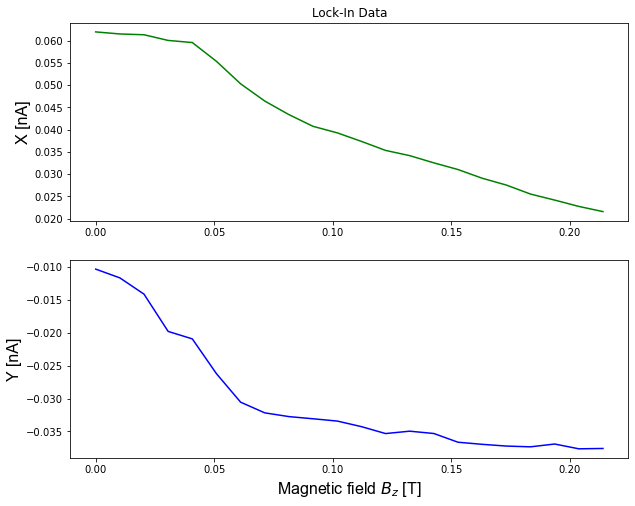

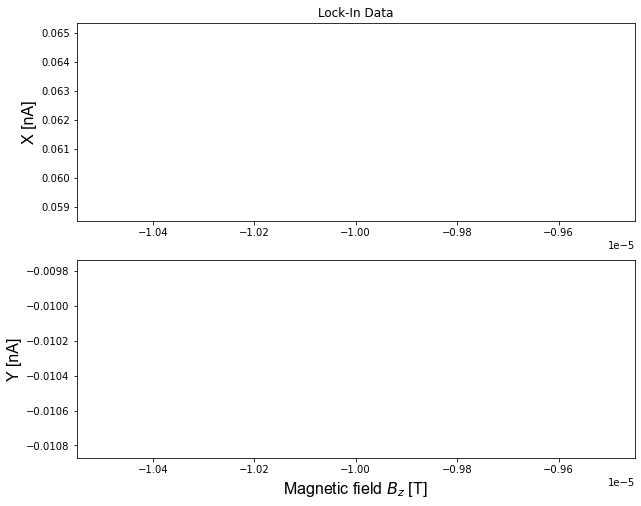

In [524]:
X = []
Y = []
Field = []

name = "experimental data/Ramping Magnetic field from 0.0T to 0.214T. BC=BM=10V, BO=0V. Osc_freq = 10003.3Hz"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)

plt.setp(ax[0].get_xticklabels(), visible=False)

final_field = 0.214                   # in [Tesla]
STEP = 0.01                        # in [Tesla]
field_steps = np.linspace(magnet.get_field(), final_field, int(abs(final_field-magnet.get_field())/STEP+1))

for i in field_steps:
    magnet.ramp_field(i)
    sleep(time_constant)
    
    voltageXY = Lock_In.read_outp_in_string()
    
    filecontent = str(i) + ',' + voltageXY
    file.write(filecontent)
    
    res = Lock_In.read_outp_in_ascii()
    X.append(float(res[0])*1e9)
    Y.append(float(res[1])*1e9)
    Field.append(i)
    
    # dynamic plot
    ax[0].cla()
    ax[1].cla()
    ax[0].set_title('Lock-In Data')
    ax[0].set_ylabel('X [nA]', fontsize=16, **hfont)
    ax[1].set_xlabel('Magnetic field $B_z$ [T]', fontsize=16, **hfont)
    ax[1].set_ylabel('Y [nA]', fontsize=16, **hfont)
    
    ax[0].plot(Field, X, 'g')
    ax[1].plot(Field, Y, 'b')
    
    hfig.update(fig)
    plt.pause(0.1)
    
file.close()
complete_sound()
telegram_notification('The measurement is complite', t_id, c_id)

# Plotting Sommer-Tanner diagram

In [525]:
xx = []
yy = []

for i in X:
    xx.append(i*1e9)
for i in Y:
    yy.append(i*1e9)

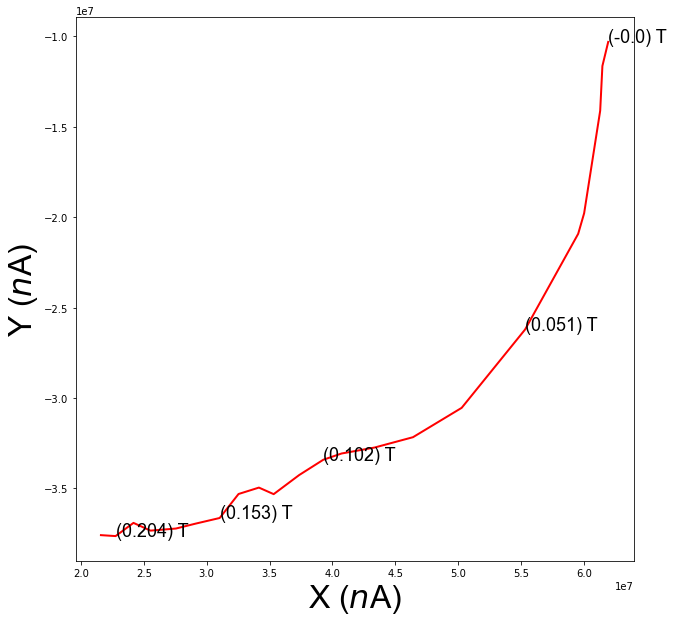

Text(0.5, 1.0, 'Sommer-Tanner diagramm. $B_z$ from 0.0T to 0.214T')

In [526]:
fig, axes = plt.subplots(1,1,figsize=(10, 10))

p = axes.plot(xx, yy, linewidth=2.0, c = 'r')

#axes.axis('tight')
axes.set_xlabel(r'X ($n$A)', fontsize=32, **hfont)
axes.set_ylabel(r'Y ($n$A)', fontsize=32, **hfont)

for index, i_x, i_y, i_f in zip(np.arange(0,np.size(xx)), xx, yy, Field):
    if (index%5 ==0): 
        plt.text(i_x, i_y, '({}) T'.format(round(i_f,3)), fontsize=18, **hfont)

plt.show()

axes.set_title('Sommer-Tanner diagramm. $B_z$ from 0.0T to 0.214T', fontsize=24, **hfont)

# Plotting Lockin vs Voltage

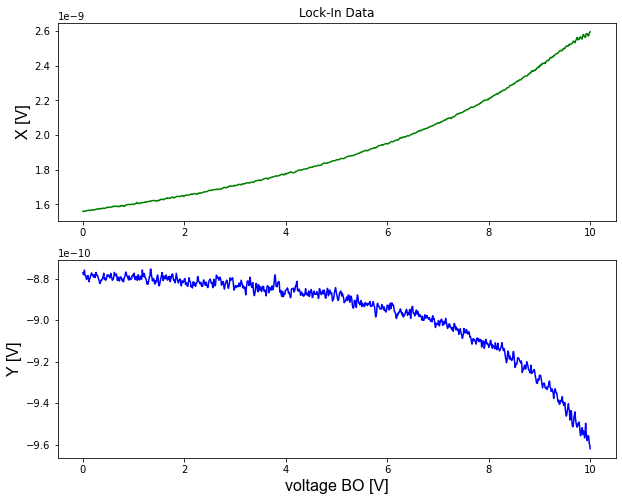

Voltage set 1e+01 V


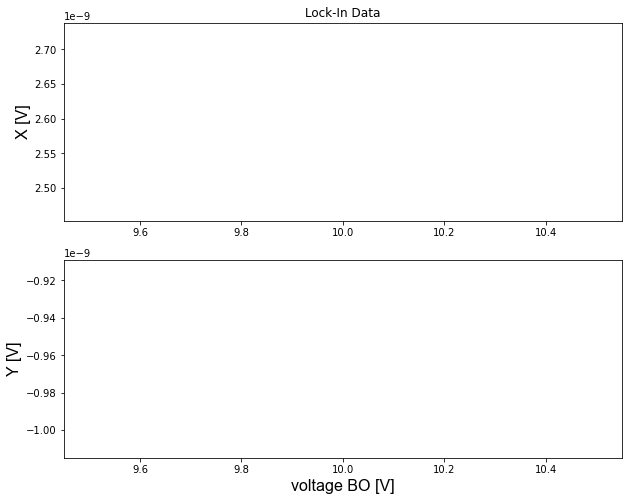

Voltage set 9.99e+00 V
Voltage set 9.98e+00 V
Voltage set 9.97e+00 V
Voltage set 9.96e+00 V
Voltage set 9.95e+00 V
Voltage set 9.94e+00 V
Voltage set 9.93e+00 V
Voltage set 9.92e+00 V
Voltage set 9.91e+00 V
Voltage set 9.9e+00 V
Voltage set 9.89e+00 V
Voltage set 9.88e+00 V
Voltage set 9.87e+00 V
Voltage set 9.86e+00 V
Voltage set 9.85e+00 V
Voltage set 9.84e+00 V
Voltage set 9.83e+00 V
Voltage set 9.82e+00 V
Voltage set 9.81e+00 V
Voltage set 9.8e+00 V
Voltage set 9.79e+00 V
Voltage set 9.78e+00 V
Voltage set 9.77e+00 V
Voltage set 9.76e+00 V
Voltage set 9.75e+00 V
Voltage set 9.74e+00 V
Voltage set 9.73e+00 V
Voltage set 9.72e+00 V
Voltage set 9.71e+00 V
Voltage set 9.7e+00 V
Voltage set 9.69e+00 V
Voltage set 9.68e+00 V
Voltage set 9.67e+00 V
Voltage set 9.66e+00 V
Voltage set 9.65e+00 V
Voltage set 9.64e+00 V
Voltage set 9.63e+00 V
Voltage set 9.62e+00 V
Voltage set 9.61e+00 V
Voltage set 9.6e+00 V
Voltage set 9.59e+00 V
Voltage set 9.58e+00 V
Voltage set 9.57e+00 V
Voltage set 9.5

Voltage set 6.41e+00 V
Voltage set 6.4e+00 V
Voltage set 6.39e+00 V
Voltage set 6.38e+00 V
Voltage set 6.37e+00 V
Voltage set 6.36e+00 V
Voltage set 6.35e+00 V
Voltage set 6.34e+00 V
Voltage set 6.33e+00 V
Voltage set 6.32e+00 V
Voltage set 6.31e+00 V
Voltage set 6.3e+00 V
Voltage set 6.29e+00 V
Voltage set 6.28e+00 V
Voltage set 6.27e+00 V
Voltage set 6.26e+00 V
Voltage set 6.25e+00 V
Voltage set 6.24e+00 V
Voltage set 6.23e+00 V
Voltage set 6.22e+00 V
Voltage set 6.21e+00 V
Voltage set 6.2e+00 V
Voltage set 6.19e+00 V
Voltage set 6.18e+00 V
Voltage set 6.17e+00 V
Voltage set 6.16e+00 V
Voltage set 6.15e+00 V
Voltage set 6.14e+00 V
Voltage set 6.13e+00 V
Voltage set 6.12e+00 V
Voltage set 6.11e+00 V
Voltage set 6.1e+00 V
Voltage set 6.09e+00 V
Voltage set 6.08e+00 V
Voltage set 6.07e+00 V
Voltage set 6.06e+00 V
Voltage set 6.05e+00 V
Voltage set 6.04e+00 V
Voltage set 6.03e+00 V
Voltage set 6.02e+00 V
Voltage set 6.01e+00 V
Voltage set 6e+00 V
Voltage set 5.99e+00 V
Voltage set 5.98e+

Voltage set 2.82e+00 V
Voltage set 2.81e+00 V
Voltage set 2.8e+00 V
Voltage set 2.79e+00 V
Voltage set 2.78e+00 V
Voltage set 2.77e+00 V
Voltage set 2.76e+00 V
Voltage set 2.75e+00 V
Voltage set 2.74e+00 V
Voltage set 2.73e+00 V
Voltage set 2.72e+00 V
Voltage set 2.71e+00 V
Voltage set 2.7e+00 V
Voltage set 2.69e+00 V
Voltage set 2.68e+00 V
Voltage set 2.67e+00 V
Voltage set 2.66e+00 V
Voltage set 2.65e+00 V
Voltage set 2.64e+00 V
Voltage set 2.63e+00 V
Voltage set 2.62e+00 V
Voltage set 2.61e+00 V
Voltage set 2.6e+00 V
Voltage set 2.59e+00 V
Voltage set 2.58e+00 V
Voltage set 2.57e+00 V
Voltage set 2.56e+00 V
Voltage set 2.55e+00 V
Voltage set 2.54e+00 V
Voltage set 2.53e+00 V
Voltage set 2.52e+00 V
Voltage set 2.51e+00 V
Voltage set 2.5e+00 V
Voltage set 2.49e+00 V
Voltage set 2.48e+00 V
Voltage set 2.47e+00 V
Voltage set 2.46e+00 V
Voltage set 2.45e+00 V
Voltage set 2.44e+00 V
Voltage set 2.43e+00 V
Voltage set 2.42e+00 V
Voltage set 2.41e+00 V
Voltage set 2.4e+00 V
Voltage set 2.39

In [38]:
X = []
Y = []
Vlt = []

name = "Ramping BO from 10 to 0. BC=BM=10V. NoField."+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)


plt.setp(ax[0].get_xticklabels(), visible=False)

final_voltage = 0.0
voltage_steps = np.linspace(current_src_BO.get_voltage(), final_voltage, int(abs(final_voltage-current_src_BO.get_voltage())/0.01+1))

for i in voltage_steps:
    #clear_output(wait=True)
    current_src_BO.set_voltage(i)
    sleep(0.5)
    
    voltageXY = Lock_In.read_outp_in_string()
    
    filecontent = str(i) + ',' + voltageXY
    file.write(filecontent)
    
    res = Lock_In.read_outp_in_ascii()
    X.append(float(res[0]))
    Y.append(float(res[1]))
    Vlt.append(i)
    
    # dynamic plot
    ax[0].cla()
    ax[1].cla()
    ax[0].set_title('Lock-In Data')
    ax[0].set_ylabel('X [V]', fontsize=16, **hfont)
    ax[1].set_xlabel('voltage BO [V]', fontsize=16, **hfont)
    ax[1].set_ylabel('Y [V]', fontsize=16, **hfont)
    
    ax[0].plot(Vlt, X, 'g')
    ax[1].plot(Vlt, Y, 'b')
    
    hfig.update(fig)
    plt.pause(0.1)
    
file.close()
lockin_complete_sound()
telegram_notification('The Lock-in measurement is complite', t_id, c_id)

In [477]:
Lock_In.read_outp_in_ascii()

[1.751256e-11, -4.034406e-11]

# Keysight E5071CA Vector network Analyzer

In [527]:
vna = Keysight_E5071C('vna', address = 'VNA')

In [13]:
vna.set_sweep_mode("LIN")

True

In [534]:
vna.set_xlim(5.7e9,6.3e9)
vna.set_nop(2001)
vna.set_average(1)
vna.set_averages(2)
vna.set_bandwidth(10)
vna.set_power(-50)

True

In [535]:
x,y = vna.get_tracedata(format = 'AMPPHA')
#x,y = vna.get_tracedata(format = 'REALIMAG')

In [536]:
vna.get_sweep_time()

192177.298497

In [531]:
freqs = vna.get_freqpoints()/1e9

In [503]:
def unwrap_phase(datapha):
    for i in range(0, len(datapha)-1):
        if datapha[i+1]-datapha[i] >= numpy.pi:
            datapha[i+1] = datapha[i+1] - 2.*numpy.pi
        elif datapha[i+1]-datapha[i] <= -numpy.pi:
            datapha[i+1] = datapha[i+1] + 2.*numpy.pi
    return datapha

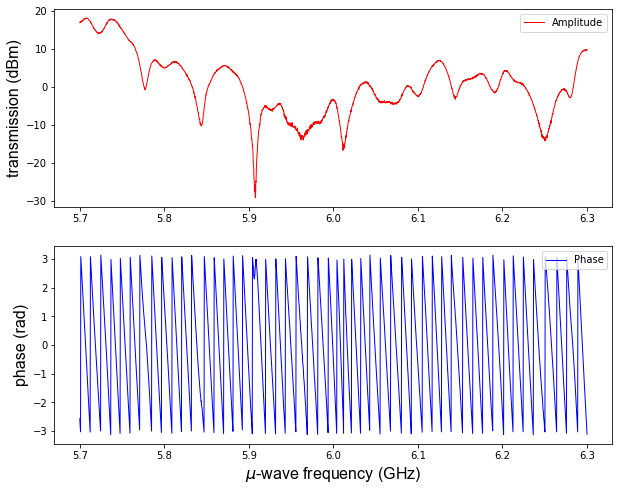

In [532]:
fig, axes = plt.subplots(2,1,figsize=(10, 8))

p = axes[0].plot(freqs, 10*np.log(x), linewidth=1.0, c = 'r', label='Amplitude')
p = axes[1].plot(freqs, y, linewidth=1.0, c = 'b', label='Phase')

#axes.axis('tight')
axes[1].set_xlabel(r'$\mu$-wave frequency (GHz)', fontsize=16, **hfont)

axes[0].set_ylabel(r'transmission (dBm)', fontsize=16, **hfont)
axes[1].set_ylabel(r'phase (rad)', fontsize=16, **hfont)

axes[0].legend()
axes[1].legend()

In [246]:
vna.set_power(-15)

True

In [248]:
x1,y1 = vna.get_tracedata(format = 'AMPPHA')

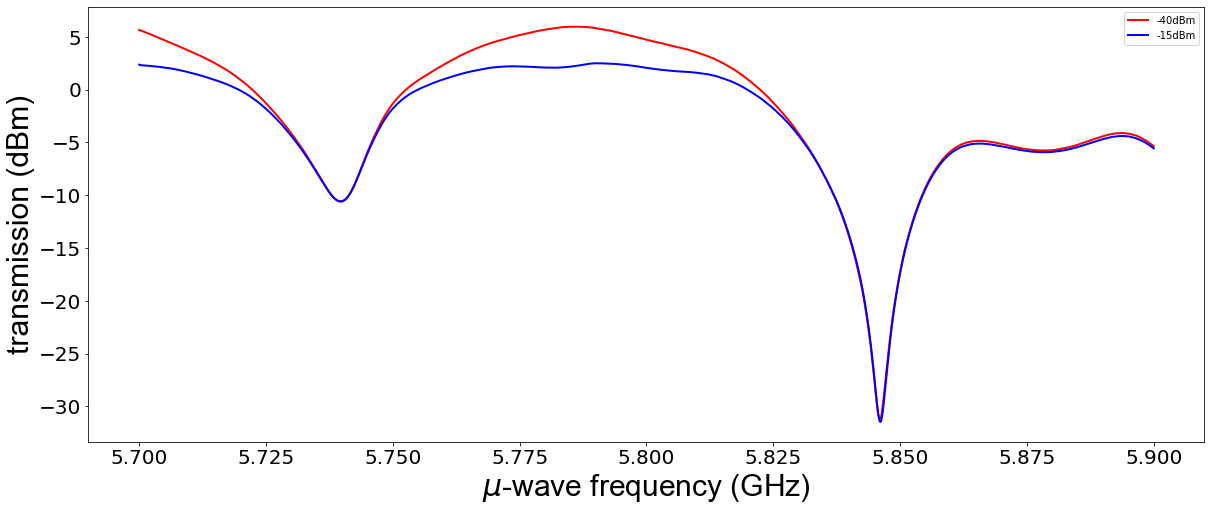

In [255]:
fig, axes = plt.subplots(1,1,figsize=(20, 8))

p = axes.plot(freqs, 10*np.log(x), linewidth=2.0, c = 'r', label='-40dBm')
p = axes.plot(freqs, 10*np.log(x1), linewidth=2.0, c = 'b', label='-15dBm')

#axes.axis('tight')
axes.set_xlabel(r'$\mu$-wave frequency (GHz)', fontsize=30, **hfont)
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

axes.set_ylabel(r'transmission (dBm)', fontsize=30, **hfont)
axes.legend()


# Plotting VNA data vs $\mu$-wave power

In [537]:
magnet.get_field()

0.21398

In [721]:
magnet.ramp_field(0.214)
magnetic_stable_sound()
print('Current Field: ' , magnet.get_field(), 'T') 
print('Landau frequency: ' , field_to_freq(magnet.get_field()), 'GHz') 

Current Field:  0.21398 T
Landau frequency:  5.992559999999999 GHz


In [722]:
vna.set_xlim(5.7e9,6.3e9)
vna.set_nop(2001)
vna.set_average(1)
vna.set_averages(2)
vna.set_bandwidth(10)
vna.set_power(-50)
sleep_time = vna.get_sweep_time()/1000

In [723]:
x,y = vna.get_tracedata(format = 'AMPPHA')

In [724]:
freq_steps = vna.get_nop()
freq=np.linspace(vna.get_startfreq()/1e9,vna.get_stopfreq()/1e9, freq_steps)       

power_steps = 100
power = np.linspace(vna.get_power(), -15, power_steps)

In [725]:
Transmission = np.zeros((power_steps,freq_steps), dtype=float)
Phase = np.zeros((power_steps,freq_steps), dtype=float)

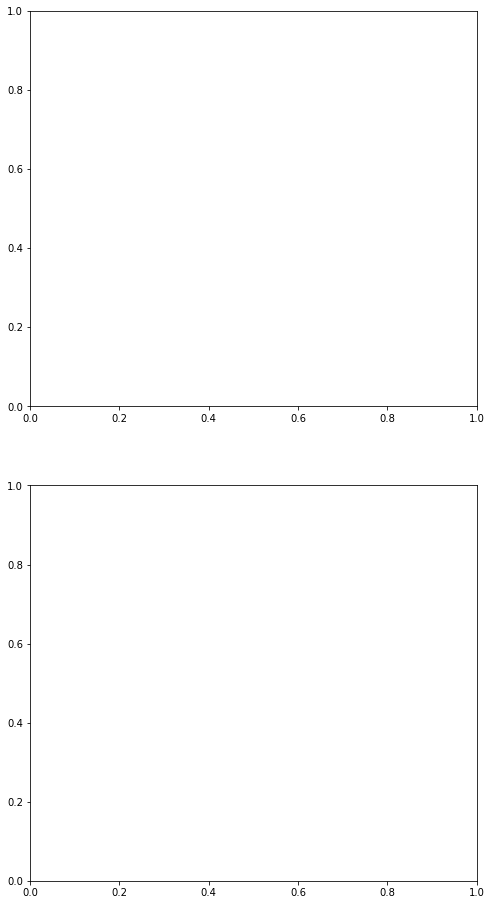

Power:  -50.0 [dBm]


KeyboardInterrupt: 

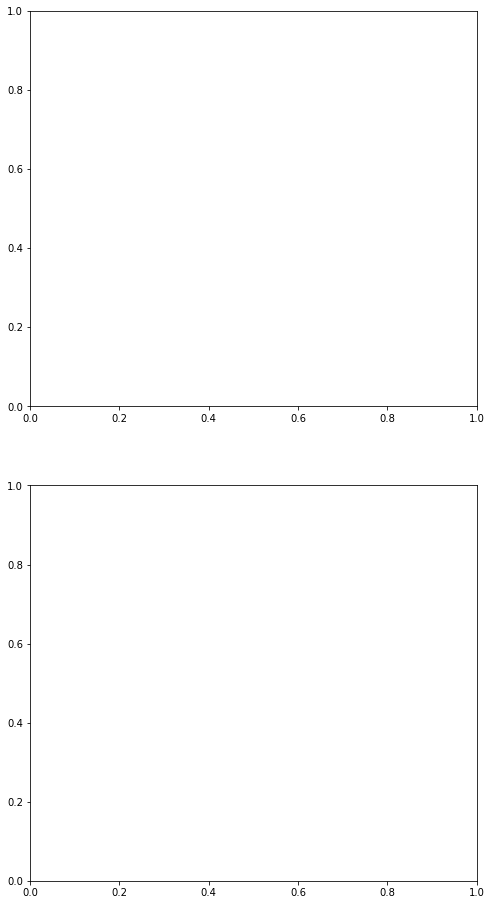

In [726]:
name = "experimental data/vna 3Dscan,power sweep from -50dBm to -15dBm. transmission"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, axes = plt.subplots(2,1,figsize=(8, 16))
hfig = display(fig, display_id=True)

for power_id, power_value in enumerate(power):
    print('Power: ', round(power_value,3), '[dBm]')
    
    vna.set_power(power_value)
    sleep(0.3)
    
    x,y = vna.get_tracedata(format = 'AMPPHA')
    sleep(sleep_time)
    sleep(0.2)
    
    
    #file.write(f"{power_value}\n")
    #for row in x:
    #    file.write(row)
    #for row in y:
    #    file.write(row)
    
    file.write(f"{power_value}\n")
    file.write(f"{x}\n")
    file.write(f"{y}\n")
    
    Transmission[power_id] = x 
    Phase[power_id] = y 

    # dynamic plot
    axes[0].cla()
    axes[1].cla()
    axes[0].set_title('VNA vs $\mu$-wave field')
    axes[0].tick_params(axis='x', labelsize=20)
    axes[0].tick_params(axis='y', labelsize=20)
    axes[1].tick_params(axis='x', labelsize=20)
    axes[1].tick_params(axis='y', labelsize=20)
    axes[0].set_ylabel('$\mu$-wave power [dBm]', fontsize=16, **hfont)
    axes[1].set_xlabel('frequency (GHz)', fontsize=16, **hfont)
    axes[1].set_ylabel('$\mu$-wave power [dBm]', fontsize=16, **hfont)
    
    p = axes[0].pcolor(freq, power, 10*np.log(Transmission), cmap=cm.bwr)
    #cb = fig.colorbar(p, ax=axes[0])
    #cb.set_label(r'transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
    #cb.ax.tick_params(labelsize=18)
    
    p = axes[1].pcolor(freq, power, Phase, cmap=cm.bwr)
    #cb = fig.colorbar(p, ax=axes[1])
    #cb.set_label(r'phase (rad)', labelpad=20, rotation=270, fontsize=24, **hfont)
    #cb.ax.tick_params(labelsize=18)
    
    hfig.update(fig)
    plt.pause(0.1)
    
file.close()
complete_sound()
telegram_notification('The measurement is complite', t_id, c_id)

In [492]:
file.close()

# substract the background

In [712]:
Transmission_nobg = np.zeros((power_steps,freq_steps), dtype=float)
for i_id,i_value in enumerate(Transmission_nobg):
    Transmission_nobg[i_id]=10*np.log(Transmission[i_id])-10*np.log(Transmission[0])

<ipython-input-712-8fa6ba2c53c2>:3: RuntimeWarning: invalid value encountered in log
  Transmission_nobg[i_id]=10*np.log(Transmission[i_id])-10*np.log(Transmission[0])


<ipython-input-713-1c9123f86e2b>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes.pcolor(freq, power, Transmission_nobg, cmap=cm.bwr)


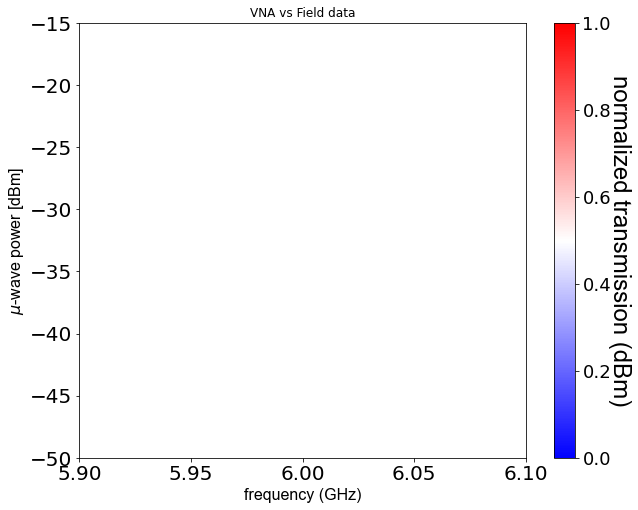

In [713]:
fig, axes = plt.subplots(1,1,figsize=(10, 8))

axes.set_title('VNA vs Field data')
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

axes.set_ylabel('$\mu$-wave power [dBm]', fontsize=16, **hfont)
axes.set_xlabel('frequency (GHz)', fontsize=16, **hfont)

p = axes.pcolor(freq, power, Transmission_nobg, cmap=cm.bwr)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'normalized transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)

# Plotting VNA data vs Magnetic field

In [751]:
magnet.get_field()

1e-05

In [752]:
freq_to_field(np.array([5.0,7.0]))

array([0.17857143, 0.25      ])

In [753]:
magnet.ramp_field(0.1785)
magnetic_stable_sound()
telegram_notification('Magnetic field is stable')
print('Current Field: ' , magnet.get_field(), 'T') 
print('Landau frequency: ' , round(field_to_freq(magnet.get_field()),4), 'GHz') 

Current Field:  0.17848 T
Landau frequency:  4.9977 GHz


In [754]:
vna.set_xlim(5.0e9,7.0e9)
vna.set_nop(2001)
vna.set_average(1)
vna.set_averages(2)
vna.set_bandwidth(100)
vna.set_power(-40)
sleep_time = vna.get_sweep_time()/1000

In [755]:
x,y = vna.get_tracedata(format = 'AMPPHA')

In [756]:
freq_steps = vna.get_nop()
freq=np.linspace(vna.get_startfreq()/1e9,vna.get_stopfreq()/1e9, freq_steps)       

field_steps = 1000
field = np.linspace(magnet.get_field(), freq_to_field(6.10), field_steps)

In [757]:
Transmission = np.zeros((field_steps,freq_steps), dtype=float)
Phase = np.zeros((field_steps,freq_steps), dtype=float)

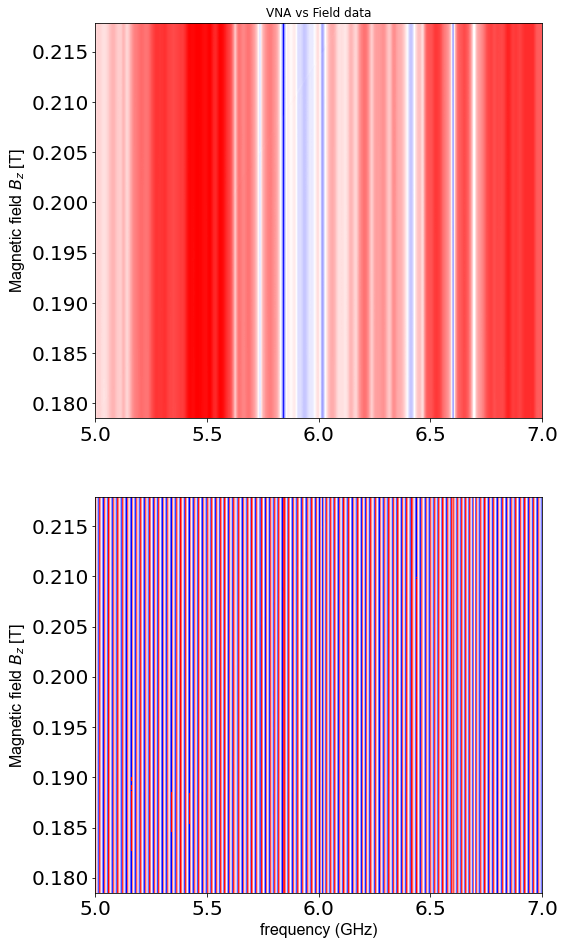

Field:  0.1785 [T]


<ipython-input-758-40587f6215da>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes[0].pcolor(freq, field, Transmission, cmap=cm.bwr)
<ipython-input-758-40587f6215da>:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes[1].pcolor(freq, field, Phase, cmap=cm.bwr)


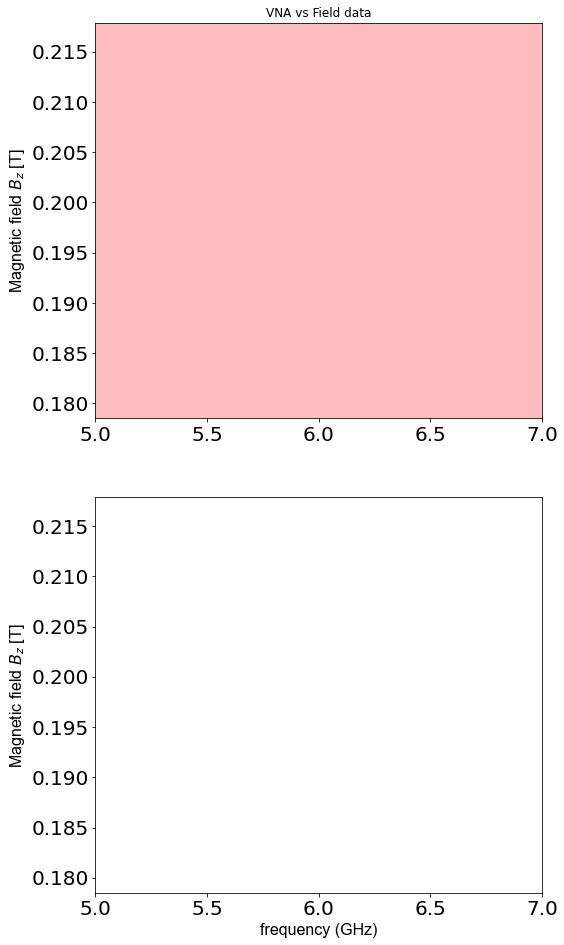

Field:  0.1785 [T]
Field:  0.1786 [T]
Field:  0.1786 [T]
Field:  0.1787 [T]
Field:  0.1787 [T]
Field:  0.1787 [T]
Field:  0.1788 [T]
Field:  0.1788 [T]
Field:  0.1789 [T]
Field:  0.1789 [T]
Field:  0.1789 [T]
Field:  0.179 [T]
Field:  0.179 [T]
Field:  0.1791 [T]
Field:  0.1791 [T]
Field:  0.1791 [T]
Field:  0.1792 [T]
Field:  0.1792 [T]
Field:  0.1792 [T]
Field:  0.1793 [T]
Field:  0.1793 [T]
Field:  0.1794 [T]
Field:  0.1794 [T]
Field:  0.1794 [T]
Field:  0.1795 [T]
Field:  0.1795 [T]
Field:  0.1796 [T]
Field:  0.1796 [T]
Field:  0.1796 [T]
Field:  0.1797 [T]
Field:  0.1797 [T]
Field:  0.1798 [T]
Field:  0.1798 [T]
Field:  0.1798 [T]
Field:  0.1799 [T]
Field:  0.1799 [T]
Field:  0.18 [T]
Field:  0.18 [T]
Field:  0.18 [T]
Field:  0.1801 [T]
Field:  0.1801 [T]
Field:  0.1802 [T]
Field:  0.1802 [T]
Field:  0.1802 [T]
Field:  0.1803 [T]
Field:  0.1803 [T]
Field:  0.1804 [T]
Field:  0.1804 [T]
Field:  0.1804 [T]
Field:  0.1805 [T]
Field:  0.1805 [T]
Field:  0.1805 [T]
Field:  0.1806 [T]
F

Field:  0.1956 [T]
Field:  0.1957 [T]
Field:  0.1957 [T]
Field:  0.1958 [T]
Field:  0.1958 [T]
Field:  0.1958 [T]
Field:  0.1959 [T]
Field:  0.1959 [T]
Field:  0.196 [T]
Field:  0.196 [T]
Field:  0.196 [T]
Field:  0.1961 [T]
Field:  0.1961 [T]
Field:  0.1961 [T]
Field:  0.1962 [T]
Field:  0.1962 [T]
Field:  0.1963 [T]
Field:  0.1963 [T]
Field:  0.1963 [T]
Field:  0.1964 [T]
Field:  0.1964 [T]
Field:  0.1965 [T]
Field:  0.1965 [T]
Field:  0.1965 [T]
Field:  0.1966 [T]
Field:  0.1966 [T]
Field:  0.1967 [T]
Field:  0.1967 [T]
Field:  0.1967 [T]
Field:  0.1968 [T]
Field:  0.1968 [T]
Field:  0.1969 [T]
Field:  0.1969 [T]
Field:  0.1969 [T]
Field:  0.197 [T]
Field:  0.197 [T]
Field:  0.1971 [T]
Field:  0.1971 [T]
Field:  0.1971 [T]
Field:  0.1972 [T]
Field:  0.1972 [T]
Field:  0.1973 [T]
Field:  0.1973 [T]
Field:  0.1973 [T]
Field:  0.1974 [T]
Field:  0.1974 [T]
Field:  0.1974 [T]
Field:  0.1975 [T]
Field:  0.1975 [T]
Field:  0.1976 [T]
Field:  0.1976 [T]
Field:  0.1976 [T]
Field:  0.1977 [T

Field:  0.2127 [T]
Field:  0.2128 [T]
Field:  0.2128 [T]
Field:  0.2129 [T]
Field:  0.2129 [T]
Field:  0.2129 [T]
Field:  0.213 [T]
Field:  0.213 [T]
Field:  0.2131 [T]
Field:  0.2131 [T]
Field:  0.2131 [T]
Field:  0.2132 [T]
Field:  0.2132 [T]
Field:  0.2132 [T]
Field:  0.2133 [T]
Field:  0.2133 [T]
Field:  0.2134 [T]
Field:  0.2134 [T]
Field:  0.2134 [T]
Field:  0.2135 [T]
Field:  0.2135 [T]
Field:  0.2136 [T]
Field:  0.2136 [T]
Field:  0.2136 [T]
Field:  0.2137 [T]
Field:  0.2137 [T]
Field:  0.2138 [T]
Field:  0.2138 [T]
Field:  0.2138 [T]
Field:  0.2139 [T]
Field:  0.2139 [T]
Field:  0.214 [T]
Field:  0.214 [T]
Field:  0.214 [T]
Field:  0.2141 [T]
Field:  0.2141 [T]
Field:  0.2142 [T]
Field:  0.2142 [T]
Field:  0.2142 [T]
Field:  0.2143 [T]
Field:  0.2143 [T]
Field:  0.2144 [T]
Field:  0.2144 [T]
Field:  0.2144 [T]
Field:  0.2145 [T]
Field:  0.2145 [T]
Field:  0.2145 [T]
Field:  0.2146 [T]
Field:  0.2146 [T]
Field:  0.2147 [T]
Field:  0.2147 [T]
Field:  0.2147 [T]
Field:  0.2148 [T

In [758]:
name = "experimental data/vna 3Dscan,Ramping Magnetic field from 0.1785T to 0.25T. -40dBm, Transmission "+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, axes = plt.subplots(2,1,figsize=(8, 16))
hfig = display(fig, display_id=True)

for field_id, field_value in enumerate(field):
    print('Field: ', round(field_value,4), '[T]')
    
    magnet.ramp_field(field_value)
    sleep(0.5)
    
    x,y = vna.get_tracedata(format = 'AMPPHA')
    sleep(sleep_time)
    sleep(0.3)

    file.write(f"{field_value}\n")
    file.write(f"{x}\n")
    file.write(f"{y}\n")
    
    Transmission[field_id] = 10*np.log(x) 
    Phase[field_id] = y 

    # dynamic plot
    axes[0].cla()
    axes[1].cla()
    axes[0].set_title('VNA vs Field data')
    axes[0].tick_params(axis='x', labelsize=20)
    axes[0].tick_params(axis='y', labelsize=20)
    axes[1].tick_params(axis='x', labelsize=20)
    axes[1].tick_params(axis='y', labelsize=20)
    axes[0].set_ylabel('Magnetic field $B_z$ [T]', fontsize=16, **hfont)
    axes[1].set_xlabel('frequency (GHz)', fontsize=16, **hfont)
    axes[1].set_ylabel('Magnetic field $B_z$ [T]', fontsize=16, **hfont)
    
    p = axes[0].pcolor(freq, field, Transmission, cmap=cm.bwr)
    p = axes[1].pcolor(freq, field, Phase, cmap=cm.bwr)

    
    hfig.update(fig)
    plt.pause(0.1)
    
#cb = fig.colorbar(p, ax=axes[0])
#cb.set_label(r'transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
#cb.ax.tick_params(labelsize=18)
#cb = fig.colorbar(p, ax=axes[1])
#cb.set_label(r'phase (rad)', labelpad=20, rotation=270, fontsize=24, **hfont)
#cb.ax.tick_params(labelsize=18)
    
file.close()
complete_sound()
telegram_notification('The measurement is complite', t_id, c_id)

<ipython-input-759-f7cbc24cc8b6>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes.pcolor(freq, field[0:95], Transmission[0:95], cmap=cm.bwr)


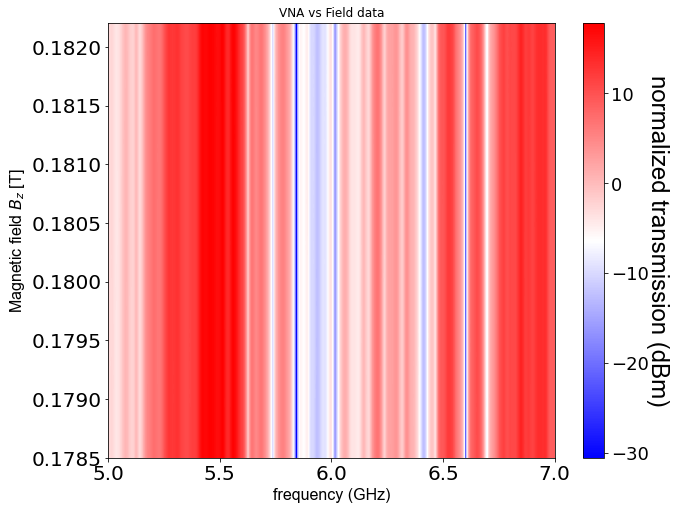

In [759]:
fig, axes = plt.subplots(1,1,figsize=(10, 8))

axes.set_title('VNA vs Field data')
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

axes.set_ylabel('Magnetic field $B_z$ [T]', fontsize=16, **hfont)
axes.set_xlabel('frequency (GHz)', fontsize=16, **hfont)

#axes.set_ylim(0.211,0.2175)

p = axes.pcolor(freq, field[0:95], Transmission[0:95], cmap=cm.bwr)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'normalized transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)

# substract the background

In [760]:
Transmission_nobg = np.zeros((field_steps,freq_steps), dtype=float)
for i_id,i_value in enumerate(Transmission_nobg):
    Transmission_nobg[i_id]=Transmission[i_id] - Transmission[1]

In [715]:
#Transmission_nobg[0]=Transmission_nobg[1]

<ipython-input-761-39683739b5ab>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = axes.pcolor(freq, field, Transmission_nobg, cmap=cm.bwr)


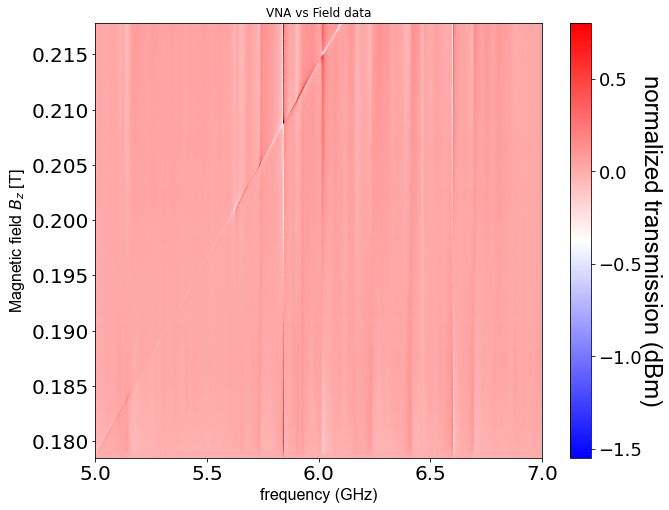

In [761]:
fig, axes = plt.subplots(1,1,figsize=(10, 8))

axes.set_title('VNA vs Field data')
axes.tick_params(axis='x', labelsize=20)
axes.tick_params(axis='y', labelsize=20)

axes.set_ylabel('Magnetic field $B_z$ [T]', fontsize=16, **hfont)
axes.set_xlabel('frequency (GHz)', fontsize=16, **hfont)

p = axes.pcolor(freq, field, Transmission_nobg, cmap=cm.bwr)

cb = fig.colorbar(p, ax=axes)
cb.set_label(r'normalized transmission (dBm)', labelpad=20, rotation=270, fontsize=24, **hfont)
cb.ax.tick_params(labelsize=18)

# Lab brick test

In [329]:
get_labbricks()

{1: {'name': 'LMS-183DX', 'serial_number': 27937}}

In [330]:
lo1 = Labbrick(name='LMS-183DX', serial=27937)

In [331]:
lo1.set_power(-20)
lo1.get_power()

-20.0

In [338]:
lo1.set_status(False)
lo1.set_power(-30)
lo1.set_frequency(6.003e9)

True

In [339]:
lo1.get_frequency()

6003000000.0

In [326]:
lo1.set_status(False)

True

In [307]:
np.array([9.16,14.17])*12

array([109.92, 170.04])

In [308]:
160/12

13.333333333333334

# Plotting Lock-in data vs lab-brick frequency (mm-waves)

In [511]:
print ("Landau frequency is: ", field_to_freq(magnet.get_field()), "[GHz]")

Landau frequency is:  5.99284 [GHz]


In [513]:
#lo1.set_power(0)                                       #for the mm-wave generation
#lo1.set_frequency(get_mult_freq(155e9))
#lo1.set_status(False)


lo1.set_power(-30)                                      #for the Landau levels excitation
lo1.set_frequency(5.8e9)
lo1.set_status(False)

Trying to set too small value: 5800000000.0


True

In [410]:
time_constant = 1.0

In [385]:
lo1.set_status(False)

True

In [414]:
lo1.set_status(True)

True

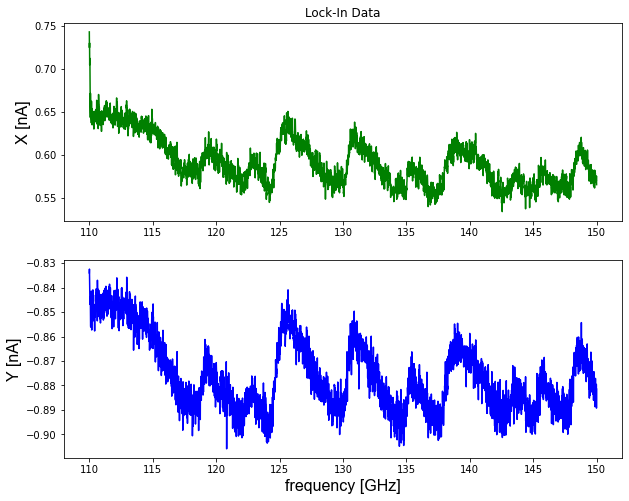

IntProgress(value=0, max=4001)

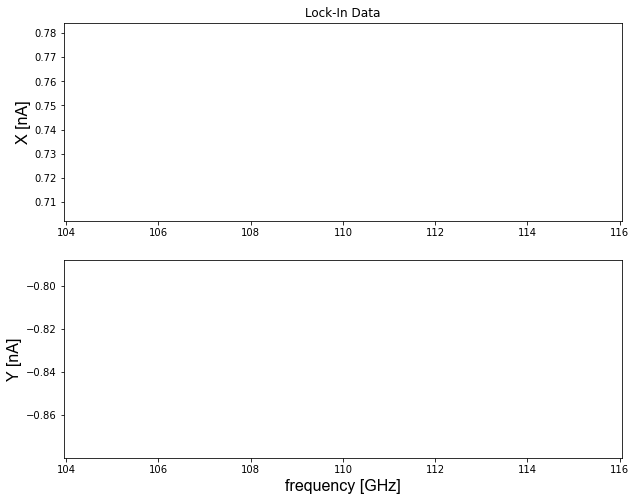

In [415]:
X = []
Y = []
Frequency = []

name = "Sweep mm-wave freq from 110GHZ to 170GHz. P=1. Osc_freq = 100033Hz"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)

plt.setp(ax[0].get_xticklabels(), visible=False)

Steps = 4001
freq_steps = np.linspace(get_mult_freq(110e9), get_mult_freq(150e9),Steps)
f = IntProgress(min=0, max=Steps)                                            # instantiate the bar
display(f)                                                                   # display the bar

for i in freq_steps:
    lo1.set_frequency(i)
    sleep(time_constant)
    
    voltageXY = Lock_In.read_outp_in_string()
    
    filecontent = str(i) + ',' + voltageXY
    file.write(filecontent)
    
    res = Lock_In.read_outp_in_ascii()
    X.append(float(res[0])*1e9)
    Y.append(float(res[1])*1e9)
    Frequency.append(get_der_freq(i)/1e9)
    
    # dynamic plot
    ax[0].cla()
    ax[1].cla()
    ax[0].set_title('Lock-In Data')
    ax[0].set_ylabel('X [nA]', fontsize=16, **hfont)
    ax[1].set_xlabel('frequency [GHz]', fontsize=16, **hfont)
    ax[1].set_ylabel('Y [nA]', fontsize=16, **hfont)
    
    ax[0].plot(Frequency, X, 'g')
    ax[1].plot(Frequency, Y, 'b')
    
    hfig.update(fig)
    plt.pause(0.1)
    f.value += 1
    
lo1.set_status(False)
file.close()
complete_sound()
telegram_notification('The measurement is complite', t_id, c_id)

# Plotting Lock-in data vs BC$\&$BM Voltage (mm-waves frequency is fixed)

In [452]:
lo1.set_power(0)
lo1.set_frequency(get_mult_freq(140e9))
lo1.set_status(False)

True

In [448]:
lo1.set_status(True)

True

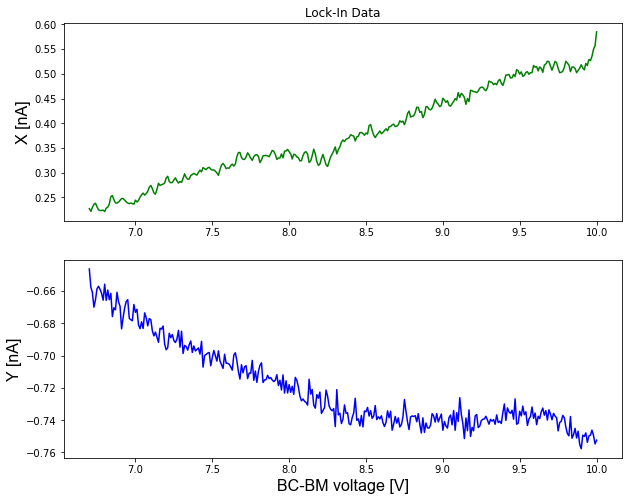

IntProgress(value=0, max=801)

Voltage set 1e+01 V
Voltage set 1e+01 V


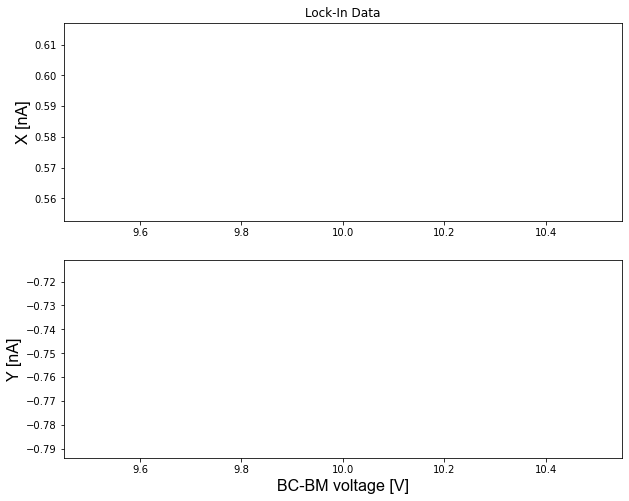

Voltage set 9.99e+00 V
Voltage set 9.99e+00 V
Voltage set 9.98e+00 V
Voltage set 9.98e+00 V
Voltage set 9.97e+00 V
Voltage set 9.97e+00 V
Voltage set 9.96e+00 V
Voltage set 9.96e+00 V
Voltage set 9.95e+00 V
Voltage set 9.95e+00 V
Voltage set 9.94e+00 V
Voltage set 9.94e+00 V
Voltage set 9.93e+00 V
Voltage set 9.93e+00 V
Voltage set 9.92e+00 V
Voltage set 9.92e+00 V
Voltage set 9.91e+00 V
Voltage set 9.91e+00 V
Voltage set 9.9e+00 V
Voltage set 9.9e+00 V
Voltage set 9.89e+00 V
Voltage set 9.89e+00 V
Voltage set 9.88e+00 V
Voltage set 9.88e+00 V
Voltage set 9.87e+00 V
Voltage set 9.87e+00 V
Voltage set 9.86e+00 V
Voltage set 9.86e+00 V
Voltage set 9.85e+00 V
Voltage set 9.85e+00 V
Voltage set 9.84e+00 V
Voltage set 9.84e+00 V
Voltage set 9.83e+00 V
Voltage set 9.83e+00 V
Voltage set 9.82e+00 V
Voltage set 9.82e+00 V
Voltage set 9.81e+00 V
Voltage set 9.81e+00 V
Voltage set 9.8e+00 V
Voltage set 9.8e+00 V
Voltage set 9.79e+00 V
Voltage set 9.79e+00 V
Voltage set 9.78e+00 V
Voltage set 9.7

Voltage set 8.2e+00 V
Voltage set 8.2e+00 V
Voltage set 8.19e+00 V
Voltage set 8.19e+00 V
Voltage set 8.18e+00 V
Voltage set 8.18e+00 V
Voltage set 8.17e+00 V
Voltage set 8.17e+00 V
Voltage set 8.16e+00 V
Voltage set 8.16e+00 V
Voltage set 8.15e+00 V
Voltage set 8.15e+00 V
Voltage set 8.14e+00 V
Voltage set 8.14e+00 V
Voltage set 8.13e+00 V
Voltage set 8.13e+00 V
Voltage set 8.12e+00 V
Voltage set 8.12e+00 V
Voltage set 8.11e+00 V
Voltage set 8.11e+00 V
Voltage set 8.1e+00 V
Voltage set 8.1e+00 V
Voltage set 8.09e+00 V
Voltage set 8.09e+00 V
Voltage set 8.08e+00 V
Voltage set 8.08e+00 V
Voltage set 8.07e+00 V
Voltage set 8.07e+00 V
Voltage set 8.06e+00 V
Voltage set 8.06e+00 V
Voltage set 8.05e+00 V
Voltage set 8.05e+00 V
Voltage set 8.04e+00 V
Voltage set 8.04e+00 V
Voltage set 8.03e+00 V
Voltage set 8.03e+00 V
Voltage set 8.02e+00 V
Voltage set 8.02e+00 V
Voltage set 8.01e+00 V
Voltage set 8.01e+00 V
Voltage set 8e+00 V
Voltage set 8e+00 V
Voltage set 7.99e+00 V
Voltage set 7.99e+00 

KeyboardInterrupt: 

In [449]:
X = []
Y = []
Voltage = []

name = "Sweep BC-BM voltage from 10V to 2V. mm_freq = 140GHz P=2. Osc_freq = 100033Hz"+datetime.datetime.now().strftime("%Y%m%d%H%M%S.txt")
file = open(name,"w")

fig, ax = plt.subplots(2,1, figsize=(10,8))
hfig = display(fig, display_id=True)

plt.setp(ax[0].get_xticklabels(), visible=False)

Steps = 801
voltage_steps = np.linspace(10, 2,Steps)
f = IntProgress(min=0, max=Steps)                                            # instantiate the bar
display(f)                                                                   # display the bar

for i in voltage_steps:
    current_src_BC.set_voltage(i)
    current_src_BM.set_voltage(i)
    sleep(time_constant)
    
    voltageXY = Lock_In.read_outp_in_string()
    
    filecontent = str(i) + ',' + voltageXY
    file.write(filecontent)
    
    res = Lock_In.read_outp_in_ascii()
    X.append(float(res[0])*1e9)
    Y.append(float(res[1])*1e9)
    Voltage.append(i)
    
    # dynamic plot
    ax[0].cla()
    ax[1].cla()
    ax[0].set_title('Lock-In Data')
    ax[0].set_ylabel('X [nA]', fontsize=16, **hfont)
    ax[1].set_xlabel('BC-BM voltage [V]', fontsize=16, **hfont)
    ax[1].set_ylabel('Y [nA]', fontsize=16, **hfont)
    
    ax[0].plot(Voltage, X, 'g')
    ax[1].plot(Voltage, Y, 'b')
    
    hfig.update(fig)
    plt.pause(0.1)
    f.value += 1
    
lo1.set_status(False)
file.close()
complete_sound()
telegram_notification('The measurement is complite', t_id, c_id)

SRS_SG386 Microwave signal generator 

A lot of troubles with an old python 2 driver here - better to rewright again

In [27]:
lo2 = SRS_SG380('SRS_SG386', address='Lo_27')  

root: WARNING  Get not implemented for SRS_SG380.timebase
root: WARNING  Get not implemented for SRS_SG380.timebase
root: WARNING  SRS_SG380 : answer to MFNC? was not expected : 3

root: WARNING  SRS_SG380 : answer to COUP? was not 0 or 1 : 0

root: WARNING  SRS_SG380 : answer to TYPE? was not expected : 3



In [28]:
lo2.get_status()

'1\r\n'

In [29]:
lo2.set_status(0)

root: WARNING  Unsupported type <class 'NoneType'>


False

In [10]:
import pyvisa

In [11]:
rm = pyvisa.ResourceManager()

In [12]:
rm.list_resources()

('ASRL1::INSTR',
 'ASRL3::INSTR',
 'ASRL4::INSTR',
 'GPIB1::5::INSTR',
 'GPIB0::10::INSTR',
 'GPIB0::16::INSTR',
 'GPIB0::17::INSTR',
 'GPIB0::1::INSTR',
 'GPIB0::22::INSTR',
 'GPIB0::26::INSTR',
 'GPIB0::2::INSTR',
 'GPIB0::3::INSTR',
 'GPIB0::4::INSTR',
 'GPIB0::5::INSTR',
 'GPIB0::6::INSTR',
 'GPIB0::7::INSTR',
 'GPIB0::8::INSTR',
 'GPIB0::9::0::INSTR',
 'TCPIP0::169.254.166.83::inst0::INSTR',
 'USB0::0x05FF::0x1023::2807N59061::0::INSTR',
 'USB0::0x0699::0x035E::C011901::0::INSTR',
 'USB0::0x0957::0x1796::MY51290236::0::INSTR',
 'USB0::0x0B5B::0xFFF9::1405051_776_47::0::INSTR',
 'USB0::0x2A8D::0xB318::MY59290070::0::INSTR')

In [32]:
my_instrument = rm.open_resource('GPIB1::5::INSTR', read_termination='\r\n')

In [36]:
print(my_instrument.query('COIL?'))

0.107100
